In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DuelingQNetwork(nn.Module):
    
    def __init__(
        self, 
        state_size, 
        action_size, 
        seed, 
        adv_fc_units=64, 
        val_fc_units=64, 
    ):

        super(DuelingQNetwork, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.adv_fc1 = nn.Linear(state_size, adv_fc_units)
        self.adv_fc2 = nn.Linear(adv_fc_units, action_size)

        self.val_fc1 = nn.Linear(state_size, val_fc_units)
        self.val_fc2 = nn.Linear(val_fc_units, 1)
        
    def forward(self, state):

        adv = F.relu(self.adv_fc1(state))
        adv = self.adv_fc2(adv)

        val = F.relu(self.val_fc1(state))
        val = self.val_fc2(val)

        return val + adv - adv.mean()


In [2]:
from dqn_agent import Agent, BUFFER_SIZE, BATCH_SIZE, LR, ReplayBuffer
import random
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DuelingAgent(Agent):
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0



In [3]:
from trainer import train
from unityagents import UnityEnvironment

In [ ]:
%%time

env = UnityEnvironment(file_name="./data/Banana.app")
agent = DuelingAgent(state_size=37, action_size=4, seed=0)
scores = train(env, agent)

In [4]:
from dqn_agent import TAU

class DuelingDoubleQAgent(DuelingAgent):
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get predicted actions for next states from local model
        next_actions = self.qnetwork_local(next_states).detach().argmax(1).unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).gather(1, next_actions)

        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)


        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.21
Episode 200	Average Score: 4.94
Episode 300	Average Score: 8.38
Episode 400	Average Score: 10.94
Episode 495	Average Score: 13.06
Environment solved in 395 episodes!	Average Score: 13.06


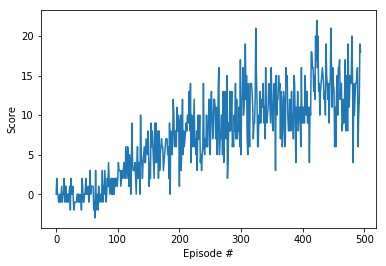

CPU times: user 3min 52s, sys: 22.7 s, total: 4min 15s
Wall time: 8min 11s


In [5]:
%%time

env = UnityEnvironment(file_name="./data/Banana.app")
agent = DuelingDoubleQAgent(state_size=37, action_size=4, seed=0)
scores = train(env, agent)

In [ ]:
env = env.reset()